# Use emcee to sample Lya posterior as a function of mean flux

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import lya_theory
import likelihood

## Setup Lya likelihood function

In [2]:
# read P1D measurement
data=data_PD2013.P1D_PD2013(blind_data=True)
zs=data.z
Nz=len(zs)

In [3]:
basedir='../../p1d_emulator/sim_suites/emulator_512_17052019/'
p1d_label='p1d'
skewers_label='Ns100_wM0.05'
undersample_z=3
use_gp=True
if use_gp:
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,undersample_z=undersample_z,verbose=True,paramList=None,kmax_Mpc=5,train=True)
else:
    emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,undersample_z=undersample_z,verbose=True)

latin hyper-cube data {'param_space': {'Om_star': {'ip': 0, 'min_val': 0.955, 'max_val': 0.975, 'z_star': 3.0, 'latex': '$\\Omega_\\star$'}, 'Delta2_star': {'ip': 1, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'n_star': {'ip': 2, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}, 'alpha_star': {'ip': 3, 'min_val': -0.265, 'max_val': -0.165, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\alpha_\\star$'}, 'mu_He': {'ip': 4, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$\\mu_{\\rm He}$'}, 'mu_H': {'ip': 5, 'min_val': 0.5, 'max_val': 2.0, '   latex': '$\\mu_{\\rm H}$'}}, 'nsamples': 10, 'samples': {'0': [0.972, 0.42000000000000004, -2.315, -0.19, 0.7250000000000001, 1.3250000000000002], '1': [0.96, 0.28, -2.295, -0.2, 1.3250000000000002, 1.475], '2': [0.966, 0.3, -2.305, -0.26, 1.025, 0.875], '3': [0.956, 0.4, -2.275, -0.25, 0.575, 1.175], '4': [0.968, 0.44, -2.325, -0.22, 1.475, 0.7250000000000001], '5': [

In [4]:
# setup theory to predict Lya 1D power
theory = lya_theory.LyaTheory(zs,emulator=emu,verbose=True)

Note: redshifts have been re-sorted (earliest first)


In [5]:
like=likelihood.Likelihood(data=data,theory=theory,verbose=True)

got parameters
g_star = 0.9677508579459803
f_star = 0.98136955784
Delta2_star = 0.360175905286
n_star = -2.29933566726
alpha_star = -0.216527037121
ln_tau_0 = -0.794580172414
ln_tau_1 = 3.18
ln_T0_0 = 9.21034037198
ln_T0_1 = 0.0
ln_gamma_0 = 0.336472236621
ln_gamma_1 = 0.0
ln_kF_0 = -1.70374859191
ln_kF_1 = 0
likelihood setup with 1 free parameters
1 free parameters


In [6]:
for p in like.free_params:
    print(p.name,p.value)

ln_tau_0 -0.794580172414


In [7]:
# test likelihood function
values=[0.5]
like.log_prob(values=values)

0 2.2 model {'Delta2_p': 0.55651130145771688, 'n_p': -2.2994794185069685, 'alpha_p': -0.21637589659957746, 'f_p': 0.96522452450210083, 'mF': 0.82678076324723049, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.13069600926052841, 'kF_Mpc': 12.672154332566837}
1 2.4 model {'Delta2_p': 0.49488568402750766, 'n_p': -2.2994795015019927, 'alpha_p': -0.21637671767578953, 'f_p': 0.97065366319224333, 'mF': 0.79400932502668009, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.12744692725288601, 'kF_Mpc': 12.995213267980114}
2 2.6 model {'Delta2_p': 0.44280074273630693, 'n_p': -2.2994793009304835, 'alpha_p': -0.21637578130992885, 'f_p': 0.97499691285123324, 'mF': 0.75832916245871795, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.12436389094838281, 'kF_Mpc': 13.317370398835509}
3 2.8 model {'Delta2_p': 0.39841920050635804, 'n_p': -2.2994793725990892, 'alpha_p': -0.21637637290771081, 'f_p': 0.97850450521187982, 'mF': 0.71997791172041337, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.12144623367196278, 'kF_Mpc': 13.6

-7038.579445436585

In [8]:
#cProfile.run("like.log_prob(values=values,linP_Mpc_params=linP_Mpc_params)",sort='cumtime')

### Setup function to be called in MCMC

In [9]:
def log_prob(values,like,verbose=False):
    test_log_prob=like.log_prob(values=values)
    if np.isnan(test_log_prob):
        if verbose:
            print('parameter values outside hull',values)
        return -np.inf
    return test_log_prob

In [10]:
like.go_silent()

In [11]:
xs=np.linspace(0.0,1.0,100)
xmin=like.free_params[0].min_value
xmax=like.free_params[0].max_value
print(xmin,'< ln_tau_0 <',xmax)
print(np.exp(xmin),'< tau_0 <',np.exp(xmax))
print(np.exp(-np.exp(xmax)),'< <F> <',np.exp(-np.exp(xmin)))
mf=np.exp(-np.exp(xmin+xs*(xmax-xmin)))
lnps=[log_prob([x],like) for x in xs]

-1.5 < ln_tau_0 < -0.4
0.223130160148 < tau_0 < 0.670320046036
0.511544833689 < <F> < 0.800010713004


Text(0, 0.5, '$\\chi^2$')

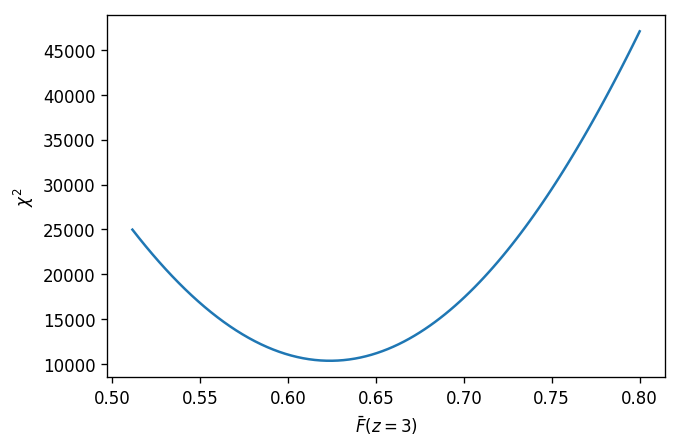

In [12]:
plt.plot(mf,-2.0*np.array(lnps))
plt.xlabel(r'$\bar F(z=3)$')
plt.ylabel(r'$\chi^2$')

### Setup MCMC

In [13]:
# for now we'll have only one dimension (mean flux)
ndim=1
# setup initial walkers
nwalkers = 10
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

In [14]:
p0.flatten()

array([ 0.96670316,  0.60828966,  0.24497332,  0.10601368,  0.54603927,
        0.47336582,  0.47502699,  0.62493856,  0.94808639,  0.6351166 ])

In [15]:
# test function
log_prob(p0[0],like)

-10992.508230662084

In [16]:
# setup sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[like])

In [17]:
# burn-in phase
pos, prob, state = sampler.run_mcmc(p0, 50)
print('finished burn-in at',pos.flatten(),prob)

finished burn-in at [ 0.68003695  0.67911928  0.67797272  0.67817955  0.6822836   0.67882305
  0.67943529  0.68213654  0.68600473  0.67840753] [-5179.75806551 -5179.87684874 -5180.17449361 -5180.10854896 -5179.91652264
 -5179.93788208 -5179.82393797 -5179.88660109 -5181.5873314  -5180.04211786]


In [18]:
# reset and run actual chains
sampler.reset()
nsteps=200
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    if i % 20 == 0:
        print(i,result[0].flatten())

0 [ 0.67982945  0.67883209  0.67797272  0.67829163  0.68237124  0.67882543
  0.67884103  0.68127518  0.6872518   0.67800248]
20 [ 0.68178715  0.67820443  0.68026039  0.67827885  0.6828829   0.68076713
  0.67878632  0.68177744  0.68078298  0.67880014]
40 [ 0.68247751  0.68067602  0.68338592  0.67982183  0.68214399  0.68233593
  0.67983564  0.68115239  0.68100869  0.67495863]
60 [ 0.67314057  0.68062909  0.67998305  0.67318015  0.68293127  0.67977252
  0.67996661  0.67906354  0.68498097  0.68317304]
80 [ 0.67460164  0.68393125  0.6788215   0.68651614  0.67769522  0.68422138
  0.67846078  0.68130533  0.68032553  0.68857068]
100 [ 0.68376565  0.67955223  0.68196794  0.68112025  0.6755774   0.67943791
  0.68120468  0.68140021  0.68376256  0.68102894]
120 [ 0.68400117  0.67726914  0.67841105  0.67996065  0.68409409  0.67232615
  0.67790696  0.67995489  0.68616139  0.67740731]
140 [ 0.67862681  0.68669917  0.68120331  0.68138838  0.68471722  0.68470738
  0.6826198   0.68052801  0.68135101  0.

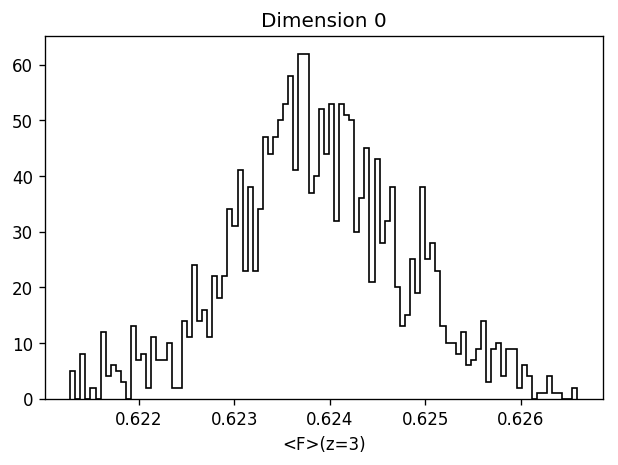

In [19]:
for i in range(ndim):
    plt.figure()
    mf=np.exp(-np.exp(xmin+sampler.flatchain[:,i]*(xmax-xmin)))
    plt.hist(mf, 100, color="k", histtype="step")
    plt.xlabel('<F>(z=3)')
    plt.title("Dimension {0:d}".format(i))

In [20]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.806


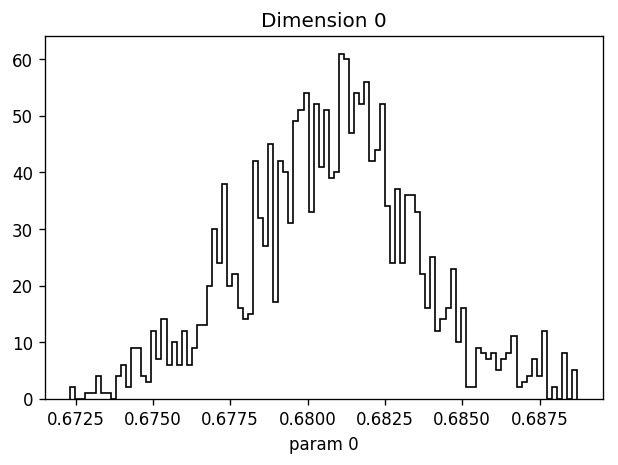

In [21]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.xlabel('param 0')
    plt.title("Dimension {0:d}".format(i))